# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/Zaidelmo/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 81 (delta 23), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 312.73 KiB | 12.51 MiB/s, done.
Resolving deltas: 100% (23/23), done.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


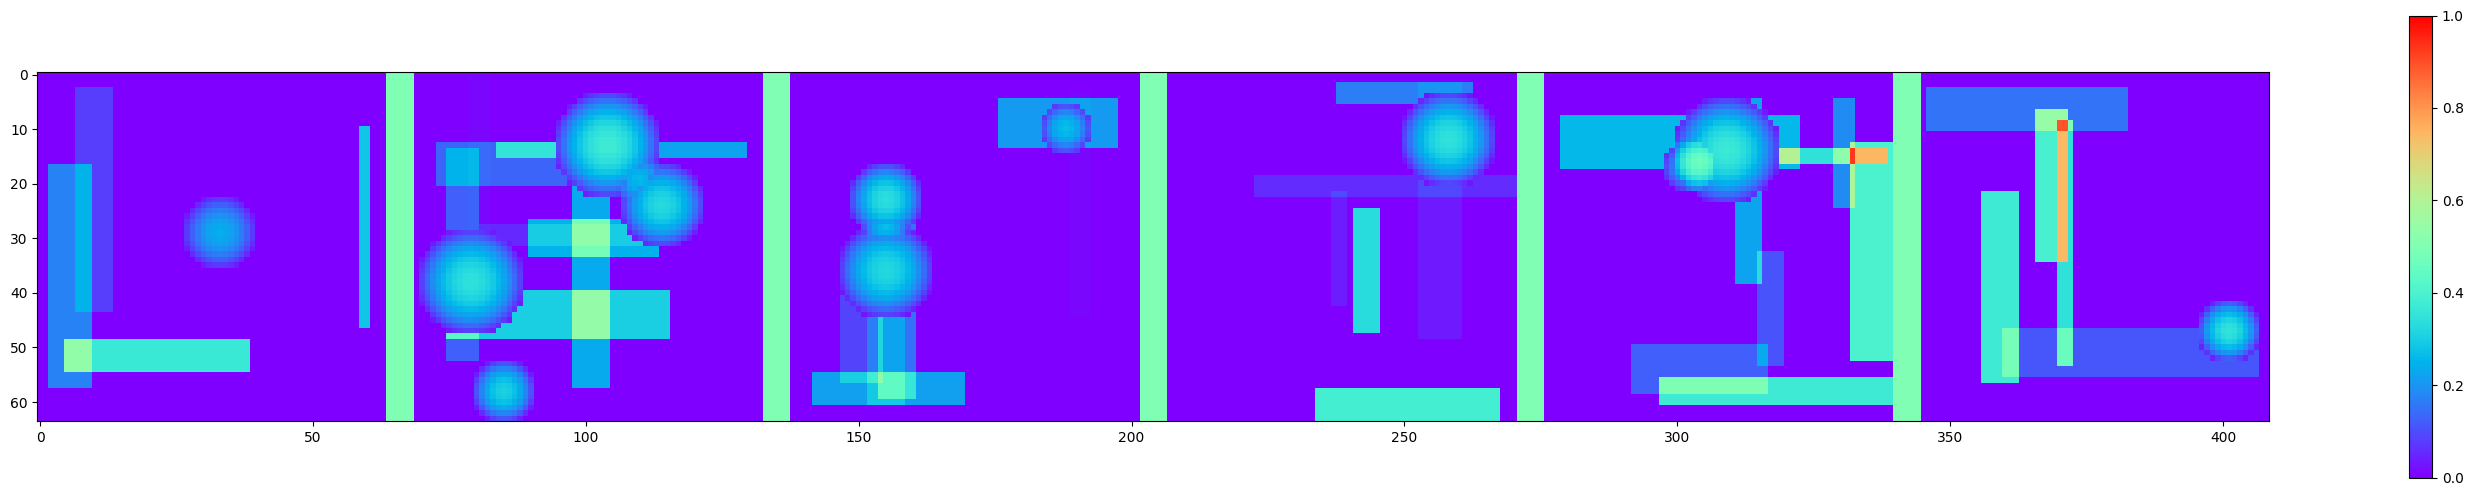

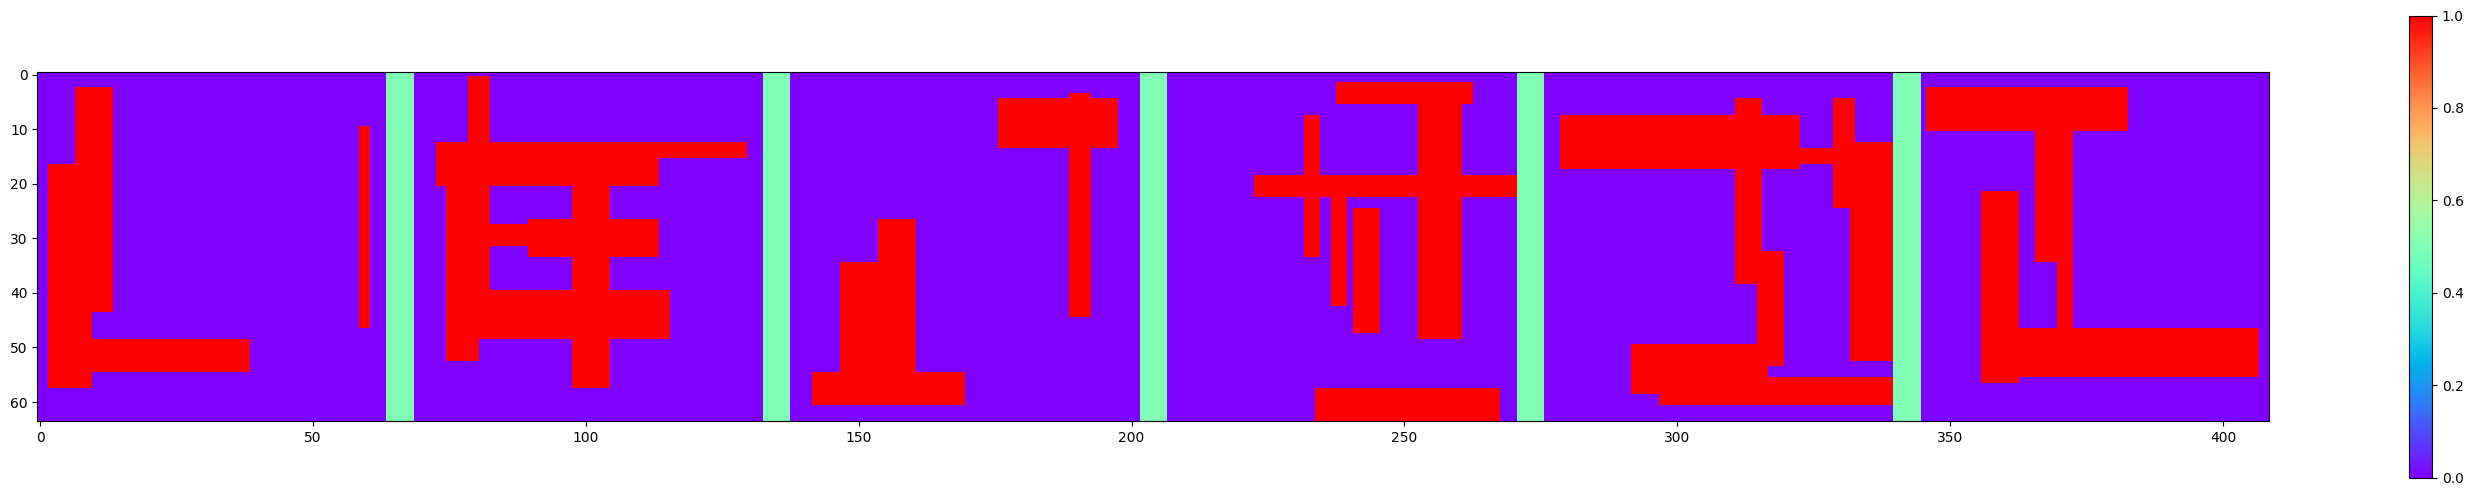

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

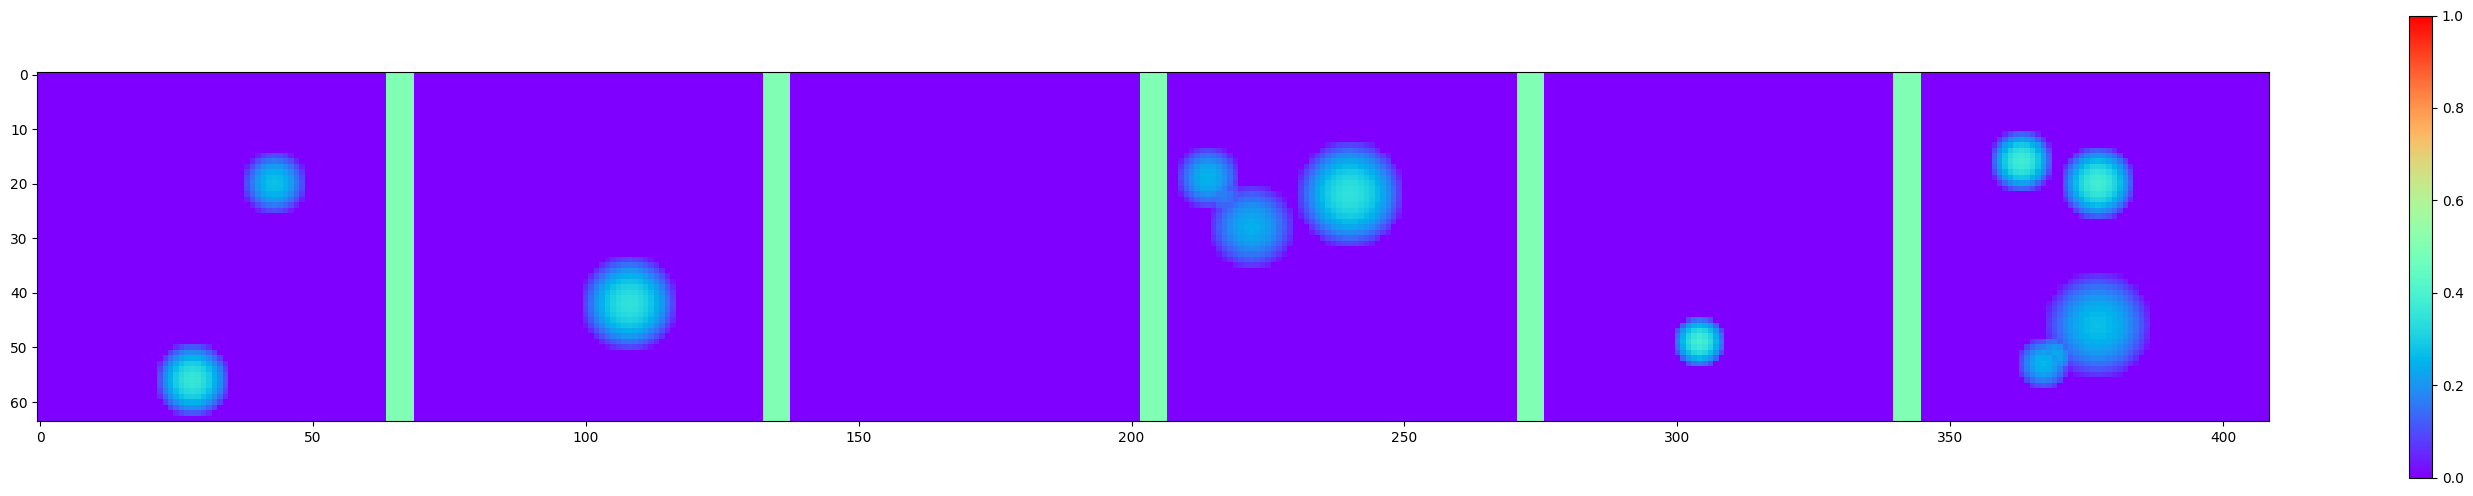

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

La supervision faible est une forme de supervision où l'étiquetage des données d'entrainements est grossier, incomplet ou inexistant (pour certaines données). Ce problème peut s'inscrire dans ce cadre vu que l'on entraine sur des données qui sont des images supposées "rectangulaires" mais qui réellement contiennent de la corruption.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

Epoch [1/50], Train Loss: 0.1938, Val Loss: 0.2295
Epoch [2/50], Train Loss: 0.0475, Val Loss: 0.4834
Epoch [3/50], Train Loss: 0.0392, Val Loss: 0.5518
Epoch [4/50], Train Loss: 0.0356, Val Loss: 0.7955
Epoch [5/50], Train Loss: 0.0267, Val Loss: 0.3854
Epoch [6/50], Train Loss: 0.0233, Val Loss: 0.2494
Epoch [7/50], Train Loss: 0.0209, Val Loss: 0.0628
Epoch [8/50], Train Loss: 0.0239, Val Loss: 0.0258
Epoch [9/50], Train Loss: 0.0218, Val Loss: 0.0279
Epoch [10/50], Train Loss: 0.0213, Val Loss: 0.0215
Epoch [11/50], Train Loss: 0.0200, Val Loss: 0.0208
Epoch [12/50], Train Loss: 0.0201, Val Loss: 0.0109
Epoch [13/50], Train Loss: 0.0164, Val Loss: 0.0141
Epoch [14/50], Train Loss: 0.0177, Val Loss: 0.0174
Epoch [15/50], Train Loss: 0.0203, Val Loss: 0.0155
Epoch [16/50], Train Loss: 0.0168, Val Loss: 0.0187
Epoch [17/50], Train Loss: 0.0155, Val Loss: 0.0183
Epoch [18/50], Train Loss: 0.0159, Val Loss: 0.0124
Epoch [19/50], Train Loss: 0.0132, Val Loss: 0.0179
Epoch [20/50], Train 

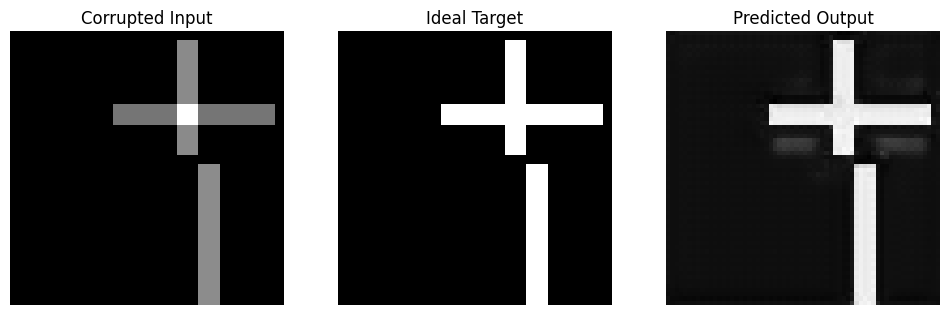

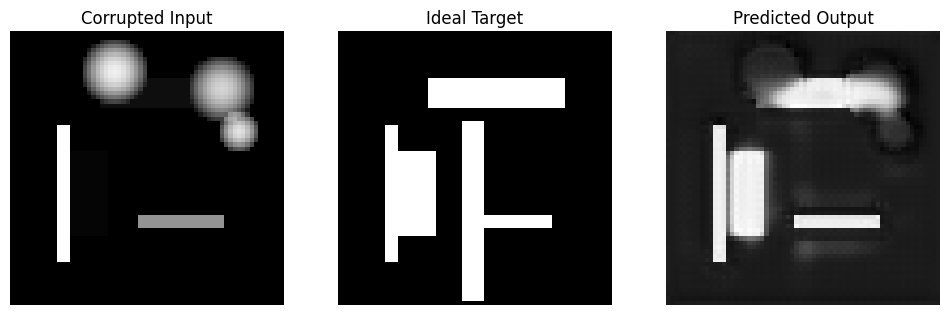

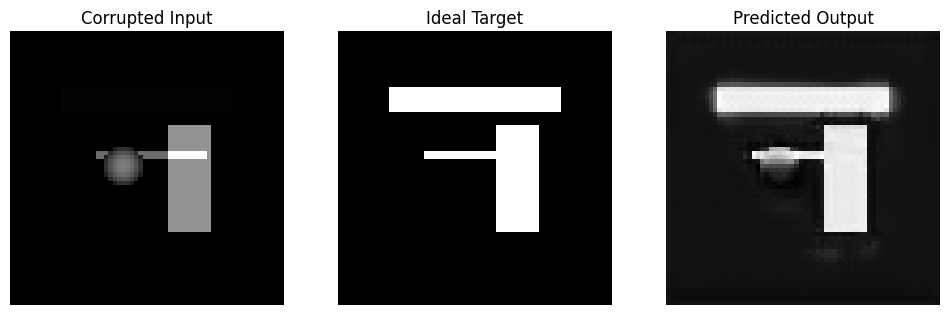

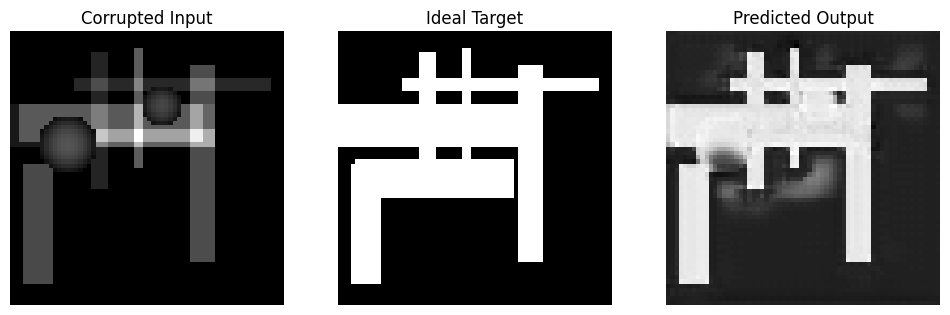

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# Choose which model to use:
use_calibration = False  # Set True to use UNet_cal; False to use basic UNet

if use_calibration:
    model = UNet_cal(n_channels=1, n_classes=1, size=64).cuda()
else:
    model = UNet(n_channels=1, n_classes=1, size=64).cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
batch_size = 16
num_batches = 10  # number of mini-batches per epoch

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for _ in range(num_batches):
        # Use your provided gen_dr to generate a batch:
        rectangles, ideal_targets = gen_dr(batch_size)
        inputs = rectangles.float().cuda()
        targets = ideal_targets.float().cuda()  # ideal_targets is a boolean mask converted to float

        optimizer.zero_grad()
        if use_calibration:
            outputs, calib = model(inputs)
            loss = criterion(outputs, targets)
            # Optionally, add additional loss on 'calib' if needed.
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / num_batches

    # Validation: using one batch of data to monitor convergence with ideal targets
    model.eval()
    with torch.no_grad():
        val_rectangles, val_ideal = gen_dr(batch_size)
        val_inputs = val_rectangles.float().cuda()
        val_targets = val_ideal.float().cuda()
        if use_calibration:
            val_outputs, val_calib = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
        else:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {val_loss.item():.4f}")

# ------------------------------
# Evaluation & Visualization
# ------------------------------

model.eval()
with torch.no_grad():
    test_rectangles, test_ideal = gen_dr(4)
    test_inputs = test_rectangles.float().cuda()
    if use_calibration:
        test_outputs, test_calib = model(test_inputs)
    else:
        test_outputs = model(test_inputs)

# Move tensors to CPU and convert to numpy arrays for plotting:
test_inputs = test_inputs.cpu().numpy()
test_ideal = test_ideal.cpu().numpy()
test_outputs = test_outputs.cpu().numpy()

import matplotlib.pyplot as plt
for i in range(4):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(test_inputs[i, 0], cmap='gray')
    axs[0].set_title("Corrupted Input")
    axs[0].axis("off")

    axs[1].imshow(test_ideal[i, 0], cmap='gray')
    axs[1].set_title("Ideal Target")
    axs[1].axis("off")

    axs[2].imshow(test_outputs[i, 0], cmap='gray')
    axs[2].set_title("Predicted Output")
    axs[2].axis("off")

    plt.show()


Epoch [1/50], Train Loss: 0.9527, Val Loss: 1.3756
Epoch [2/50], Train Loss: 0.6795, Val Loss: 1.5870
Epoch [3/50], Train Loss: 0.5654, Val Loss: 2.1491
Epoch [4/50], Train Loss: 0.4696, Val Loss: 2.2681
Epoch [5/50], Train Loss: 0.4160, Val Loss: 2.1561
Epoch [6/50], Train Loss: 0.3746, Val Loss: 0.5902
Epoch [7/50], Train Loss: 0.3228, Val Loss: 0.3284
Epoch [8/50], Train Loss: 0.3141, Val Loss: 0.3134
Epoch [9/50], Train Loss: 0.2791, Val Loss: 0.2883
Epoch [10/50], Train Loss: 0.2737, Val Loss: 0.3111
Epoch [11/50], Train Loss: 0.2696, Val Loss: 0.2613
Epoch [12/50], Train Loss: 0.2719, Val Loss: 0.2681
Epoch [13/50], Train Loss: 0.2638, Val Loss: 0.2264
Epoch [14/50], Train Loss: 0.2693, Val Loss: 0.2989
Epoch [15/50], Train Loss: 0.2677, Val Loss: 0.3041
Epoch [16/50], Train Loss: 0.2516, Val Loss: 0.2184
Epoch [17/50], Train Loss: 0.2788, Val Loss: 0.2075
Epoch [18/50], Train Loss: 0.2395, Val Loss: 0.2766
Epoch [19/50], Train Loss: 0.2355, Val Loss: 0.2048
Epoch [20/50], Train 

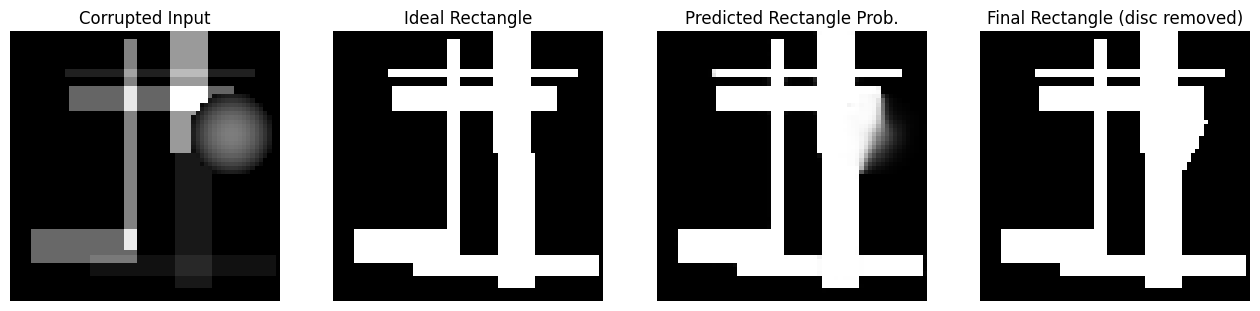

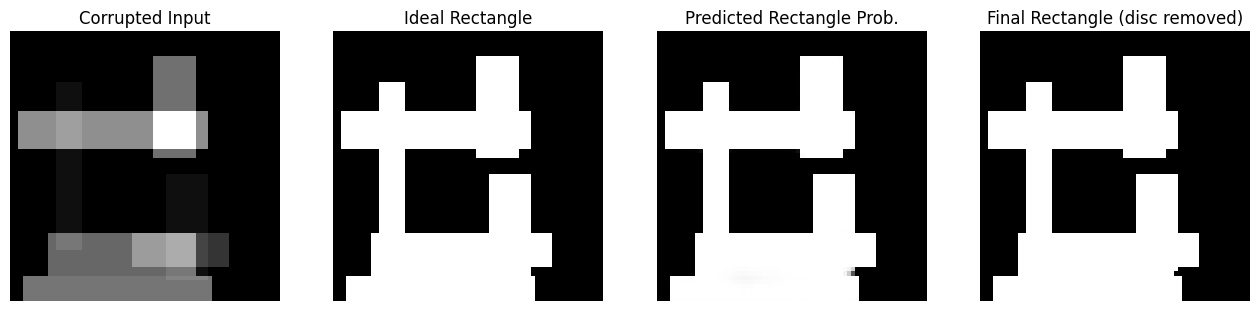

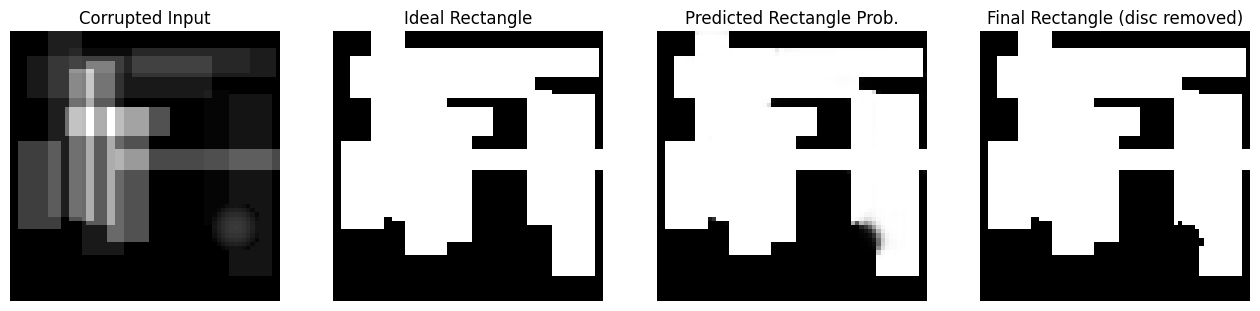

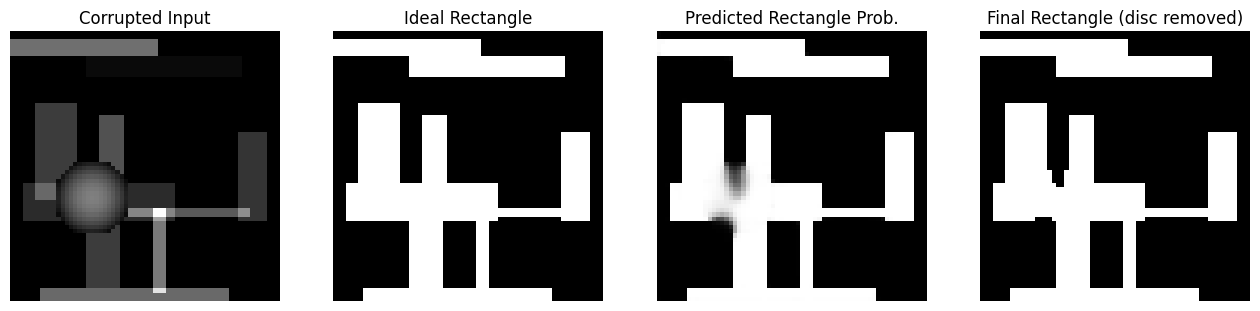

Mean IoU: 0.988088071346283


In [27]:
def compute_iou(pred, target, smooth=1e-6):
    """
    Compute the Intersection over Union (IoU) between predicted and target masks.
    Both pred and target should be binary masks of shape [B, 1, H, W].
    """
    # Ensure binary masks (they should already be, but for safety)
    pred_bin = (pred > 0.5).float()
    target_bin = (target > 0.5).float()

    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - intersection
    return (intersection + smooth) / (union + smooth)


# --- Multi-Task Training Loop ---

# We assume the UNet definition has not changed.
# Set the network to output 2 channels: channel 0 for rectangles, channel 1 for discs.
model = UNet(n_channels=1, n_classes=2, size=64).cuda()

# For binary segmentation tasks, BCEWithLogitsLoss is more appropriate.
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
batch_size = 16
num_batches = 10  # Number of mini-batches per epoch

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for _ in range(num_batches):
        # Generate a batch for rectangle segmentation:
        # corrupted_rect: corrupted image with discs applied to rectangles
        # rect_ideal: ideal (clean) rectangle mask (boolean)
        corrupted_rect, rect_ideal = gen_dr(batch_size)

        # Generate a batch for discs segmentation using gen_d:
        disc_images = gen_d(batch_size)
        # Convert disc images into a binary mask (thresholding > 0)
        disc_ideal = (disc_images > 0).float()

        # Prepare inputs and targets (converted to float)
        inputs = corrupted_rect.float().cuda()  # Input image (with corruption)
        rect_target = rect_ideal.float().cuda()   # Ideal rectangle mask
        disc_target = disc_ideal.cuda()             # Ideal disc mask

        optimizer.zero_grad()
        outputs = model(inputs)  # Expected output shape: (B, 2, H, W)

        # Separate the network's outputs into rectangle and disc predictions while preserving channel dimension:
        rect_out = outputs[:, 0:1, :, :]  # shape: (B, 1, H, W)
        disc_out = outputs[:, 1:2, :, :]    # shape: (B, 1, H, W)

        # Compute separate losses for each task:
        loss_rect = criterion(rect_out, rect_target)
        loss_disc = criterion(disc_out, disc_target)

        # Combine the losses (you could weight these differently if desired)
        loss = loss_rect + loss_disc

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / num_batches

    # Validation: similar multi-task supervision on a single batch.
    model.eval()
    with torch.no_grad():
        val_corrupted, val_rect_ideal = gen_dr(batch_size)
        val_disc_images = gen_d(batch_size)
        val_disc_ideal = (val_disc_images > 0).float()

        val_inputs = val_corrupted.float().cuda()
        val_rect_target = val_rect_ideal.float().cuda()
        val_disc_target = val_disc_ideal.cuda()

        val_outputs = model(val_inputs)
        val_rect_out = val_outputs[:, 0:1, :, :]
        val_disc_out = val_outputs[:, 1:2, :, :]

        val_loss_rect = criterion(val_rect_out, val_rect_target)
        val_loss_disc = criterion(val_disc_out, val_disc_target)
        val_loss = val_loss_rect + val_loss_disc

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss.item():.4f}")

# --- Evaluation & Combining Predictions ---

model.eval()
with torch.no_grad():
    test_corrupted, test_rect_ideal = gen_dr(4)
    test_disc_images = gen_d(4)

    test_inputs = test_corrupted.float().cuda()
    test_outputs = model(test_inputs)

    # Separate outputs for rectangles and discs.
    test_rect_out = test_outputs[:, 0:1, :, :]
    test_disc_out = test_outputs[:, 1:2, :, :]

    # Apply sigmoid to get probabilities.
    test_rect_prob = torch.sigmoid(test_rect_out)
    test_disc_prob = torch.sigmoid(test_disc_out)

    # For a final prediction you might want to "remove" disc areas from the rectangle prediction.
    # For example, using a threshold of 0.5 on each:
    #alpha = 0.7  # weight for the rectangle confidence
    #final_rect = ((test_rect_prob > 0.5) | ((test_rect_prob - test_disc_prob) > 0.3)).float()
    final_rect = ((test_rect_prob > 0.5) & (test_disc_prob < 0.5)).float()
    # Move tensors to CPU for visualization.
    test_inputs_np = test_inputs.cpu().numpy()
    test_rect_ideal_np = test_rect_ideal.cpu().numpy()
    final_rect_np = final_rect.cpu().numpy()
import matplotlib.pyplot as plt
for i in range(4):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(test_inputs_np[i, 0], cmap='gray')
    axs[0].set_title("Corrupted Input")
    axs[0].axis("off")

    axs[1].imshow(test_rect_ideal_np[i, 0], cmap='gray')
    axs[1].set_title("Ideal Rectangle")
    axs[1].axis("off")

    # Optionally, display the raw predicted rectangle probabilities.
    axs[2].imshow(test_rect_prob.cpu().numpy()[i, 0], cmap='gray')
    axs[2].set_title("Predicted Rectangle Prob.")
    axs[2].axis("off")

    axs[3].imshow(final_rect_np[i, 0], cmap='gray')
    axs[3].set_title("Final Rectangle (disc removed)")
    axs[3].axis("off")

    plt.show()
final_rect_cpu = final_rect.cpu()
ideal_cpu = test_rect_ideal.float().cpu()
iou_score = compute_iou(final_rect_cpu, ideal_cpu)
print("Mean IoU:", iou_score.item())

J'ai essayé deux approches différentes: Sur la premiere approche, on utilise une segmentation simple pour detecter les rectangles avec une MSE comme fonction de loss, le resultat en terme d'erreurs etait satisfaisant mais visuellement très pérturbé. La deuxième approche m'est venu en pensant a exploité la fonction gen_d, en faisant de la segmentation multi-tache on peut predire les rectangles et les disque puis faire une elimination des disque avec une metrique de probabilité, les deux pertinentes qui me sont venues à l'esprit sont : final_rect = ((test_rect_prob > 0.5) & (test_disc_prob < 0.5)).float() mais celle ci prend moins en compte les points d'intersections entres les deux ou les deux probabilitées peuvent etre fortes, et donc je propose celle la aussi: ((test_rect_prob > 0.5) | ((test_rect_prob - test_disc_prob) > 0.3)).float().
Ces metriques fournissent un score IOU moyen dans les 98-99 ce qui est assez satisfaisant.


\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




tensor([3.5531, 6.2895, 1.7176, 1.8502, 7.0035, 4.1755])


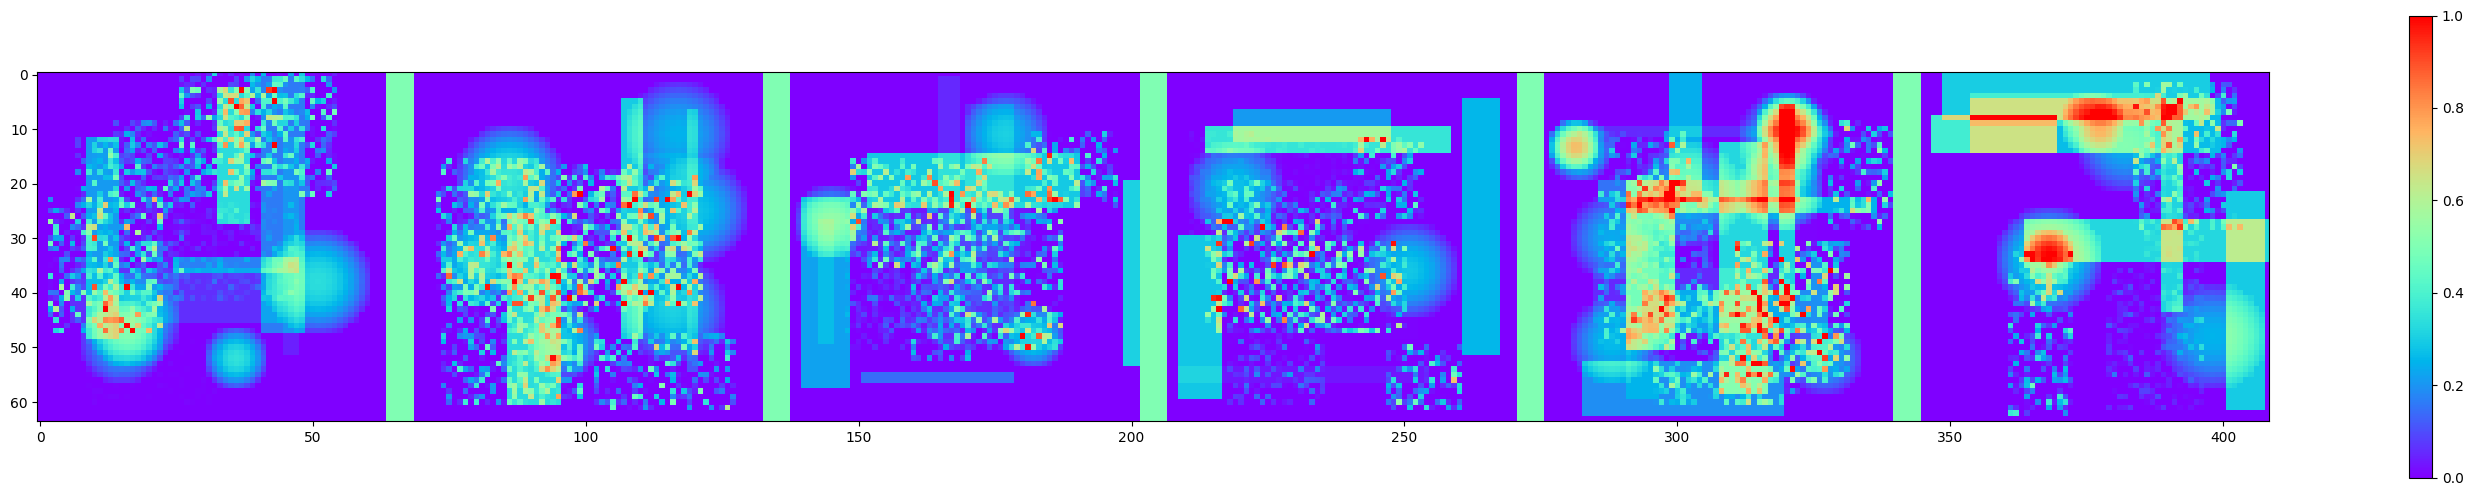

tensor([5.3702, 5.4618, 0.2320, 1.2641, 5.1890, 3.7967])


In [28]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

In [30]:
from torch.utils.data import TensorDataset, DataLoader
# Create a TensorDataset from the inputs and targets
dataset = TensorDataset(inputs, targets)

# Create a DataLoader from the TensorDataset
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2)

# Iterate over the DataLoader
for batch_inputs, batch_targets in data_loader:
    print("Batch inputs shape:", batch_inputs.shape)
    print("Batch targets shape:", batch_targets.shape)
    break  # Remove break to iterate over all batches

Batch inputs shape: torch.Size([2, 1, 64, 64])
Batch targets shape: torch.Size([2])


**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [37]:
from torchvision.models import resnet18
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt
model = models.resnet18(pretrained=False)
# Modify the first convolution layer to accept 1 channel instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Modify the final fully connected layer to output 1 value (for regression)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)


# Define the loss function and optimizer.
# L1Loss is used here because minimizing L1 error corresponds to estimating the median.
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Set up a simple training loop.
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_inputs, batch_targets in data_loader:
        # Move data to the device.
        batch_inputs = batch_inputs
        batch_targets = batch_targets.view(-1, 1)  # reshape targets to [batch_size, 1]

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_inputs.size(0)
    epoch_loss /= len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/50, Loss: 3.0026
Epoch 2/50, Loss: 1.4812
Epoch 3/50, Loss: 2.5113
Epoch 4/50, Loss: 2.0768
Epoch 5/50, Loss: 1.4593
Epoch 6/50, Loss: 1.1707
Epoch 7/50, Loss: 0.9708
Epoch 8/50, Loss: 1.1189
Epoch 9/50, Loss: 0.7128
Epoch 10/50, Loss: 0.4760
Epoch 11/50, Loss: 0.5846
Epoch 12/50, Loss: 0.4964
Epoch 13/50, Loss: 0.4930
Epoch 14/50, Loss: 0.8970
Epoch 15/50, Loss: 0.4261
Epoch 16/50, Loss: 0.7850
Epoch 17/50, Loss: 0.4295
Epoch 18/50, Loss: 0.6700
Epoch 19/50, Loss: 0.6869
Epoch 20/50, Loss: 0.4128
Epoch 21/50, Loss: 0.4004
Epoch 22/50, Loss: 0.3127
Epoch 23/50, Loss: 0.8240
Epoch 24/50, Loss: 0.6906
Epoch 25/50, Loss: 0.3626
Epoch 26/50, Loss: 0.4015
Epoch 27/50, Loss: 0.4879
Epoch 28/50, Loss: 0.2900
Epoch 29/50, Loss: 0.3625
Epoch 30/50, Loss: 0.3951
Epoch 31/50, Loss: 0.3737
Epoch 32/50, Loss: 0.3200
Epoch 33/50, Loss: 0.6086
Epoch 34/50, Loss: 0.2583
Epoch 35/50, Loss: 0.3230
Epoch 36/50, Loss: 0.4039
Epoch 37/50, Loss: 0.4583
Epoch 38/50, Loss: 0.4745
Epoch 39/50, Loss: 0.

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

In [38]:
# Load the ResNet18 model and adjust it.
model = models.resnet18(pretrained=False)
# If your images are 1-channel, modify the first conv layer to accept 1 channel.
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Change the final layer to output 3 values (for the three quantiles).
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)


# Define the quantile (pinball) loss function.
def quantile_loss(y_true, y_pred, quantile):
    error = y_true - y_pred
    return torch.mean(torch.max(quantile * error, (quantile - 1) * error))

# Set up the optimizer.
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop.
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_inputs, batch_targets in data_loader:
        batch_inputs = batch_inputs
        batch_targets = batch_targets.view(-1, 1)  # Ensure shape is [batch_size, 1]

        optimizer.zero_grad()
        outputs = model(batch_inputs)  # outputs shape: [batch_size, 3]

        # Compute loss for each quantile:
        loss_q1 = quantile_loss(batch_targets, outputs[:, 0:1], 0.25)  # 1st quantile (25th percentile)
        loss_q2 = quantile_loss(batch_targets, outputs[:, 1:2], 0.5)   # Median (50th percentile)
        loss_q3 = quantile_loss(batch_targets, outputs[:, 2:3], 0.75)  # 3rd quantile (75th percentile)

        loss = loss_q1 + loss_q2 + loss_q3
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_inputs.size(0)

    epoch_loss /= len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50, Loss: 4.3379
Epoch 2/50, Loss: 2.3528
Epoch 3/50, Loss: 3.0961
Epoch 4/50, Loss: 1.3598
Epoch 5/50, Loss: 2.1326
Epoch 6/50, Loss: 1.9201
Epoch 7/50, Loss: 1.3113
Epoch 8/50, Loss: 1.2017
Epoch 9/50, Loss: 0.8921
Epoch 10/50, Loss: 0.6374
Epoch 11/50, Loss: 0.9303
Epoch 12/50, Loss: 0.8737
Epoch 13/50, Loss: 0.6576
Epoch 14/50, Loss: 0.6582
Epoch 15/50, Loss: 0.6628
Epoch 16/50, Loss: 0.4192
Epoch 17/50, Loss: 0.7098
Epoch 18/50, Loss: 0.5359
Epoch 19/50, Loss: 0.4072
Epoch 20/50, Loss: 0.4976
Epoch 21/50, Loss: 0.3644
Epoch 22/50, Loss: 0.4506
Epoch 23/50, Loss: 0.4377
Epoch 24/50, Loss: 0.3644
Epoch 25/50, Loss: 0.5659
Epoch 26/50, Loss: 0.5554
Epoch 27/50, Loss: 0.4581
Epoch 28/50, Loss: 0.3653
Epoch 29/50, Loss: 0.3596
Epoch 30/50, Loss: 0.3482
Epoch 31/50, Loss: 0.4512
Epoch 32/50, Loss: 0.3954
Epoch 33/50, Loss: 0.4799
Epoch 34/50, Loss: 0.2598
Epoch 35/50, Loss: 0.3731
Epoch 36/50, Loss: 0.3189
Epoch 37/50, Loss: 0.4713
Epoch 38/50, Loss: 0.4156
Epoch 39/50, Loss: 0.

La fonction de perte utilisée s'appelle la fonction de perte pinball (ou quantile).

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

In [42]:
# Set the model to evaluation mode.
model.eval()

# Generate a test batch of 64 samples.
inputs_test, targets_test = gen_ex2(64)

# Move the inputs to the same device as the model.
inputs_test = inputs_test

# Disable gradient computation for evaluation.
with torch.no_grad():
    # Get the model outputs for the test inputs.
    # Expected output shape is [64, 3], where:
    # - outputs[:, 0] is the predicted 25th quantile,
    # - outputs[:, 1] is the predicted median,
    # - outputs[:, 2] is the predicted 75th quantile.
    outputs_test = model(inputs_test)

# Compute the interquantile range (IQR) for each sample.
# IQR = 75th quantile - 25th quantile.
iqr_test = outputs_test[:, 2] - outputs_test[:, 0]

# Compute the average IQR over the batch.
mean_iqr = iqr_test.mean()

# Compute the standard deviation of the IQR over the batch.
std_iqr = iqr_test.std()
print("Interquantile Range for each sample in the batch:")
print(iqr_test)
print("Average IQR over the batch:", mean_iqr.item())
print("Standard Deviation of IQR over the batch:", std_iqr.item())


tensor([5.8989, 6.0779, 4.8756, 5.6627, 2.3047, 4.9915, 4.8390, 6.4140, 6.5186,
        3.1828, 3.2117, 8.1882, 5.7156, 6.2593, 4.0867, 6.6044, 4.3870, 3.1363,
        2.8113, 4.9538, 3.2612, 4.0341, 9.9599, 5.1232, 6.3854, 5.1801, 7.3443,
        6.8002, 4.9589, 1.9654, 4.5167, 4.8102, 2.0129, 4.7628, 6.7215, 5.8391,
        4.7316, 7.5123, 4.0714, 4.6162, 4.3510, 3.9924, 9.7949, 3.8797, 4.7429,
        4.6224, 1.3687, 3.1089, 5.7459, 5.1612, 4.0173, 8.7057, 3.0122, 5.4930,
        3.8129, 5.7989, 3.1981, 2.0988, 3.1455, 2.8484, 7.9756, 4.7778, 1.3162,
        4.4899])
Interquantile Range for each sample in the batch:
tensor([0.7987, 0.7873, 0.7596, 0.6984, 0.6692, 0.6804, 0.6839, 0.7209, 0.7633,
        0.8069, 0.7851, 0.7138, 0.6084, 0.6295, 0.7262, 0.7182, 0.7869, 0.7404,
        0.8280, 0.5814, 0.7155, 0.8084, 0.6415, 0.7014, 0.6351, 0.6920, 0.6386,
        0.5402, 0.7481, 0.8076, 0.7071, 0.7219, 0.5804, 0.8070, 0.6980, 0.7498,
        0.7084, 0.7578, 0.7740, 0.7405, 0.6636, 0.765

L'ecart type des ecart qunatiles est extremement faible, les valeurs sont donc fortement rapprochés et ne semblent pas dépendre de l'image. (Un print sur toutes les valeurs des écarts confirme cela).

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

Afin de confirmer notre theorie nous pourrions tester notre modèle sur des images ne contenant que des disques et voir si les predictions sont similaires. On pourra utiliser les ecart interquantiles comme facteurs vu que l'on a pu detecter qu'ils restent presque constant.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

In [ ]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

In [ ]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

"Domain Adaptation" décrit la problématique d'entrainement d'un modèle sur des données qui existe dans le meme espace mais à distribution différente que les données d'inférences. Dans notre cas les données disponibles à l'entrainement sont effectivement des photos de rectangles corrompus par des disques, mais certaines caractéristiques sont largement différentes (la densité des figure géometriques sur l'image).

**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

Starting training...

Epoch [1/30] | Model_DR Train Loss: 1.0392 | Model_DR_Train Train Loss: 1.1894
Epoch [2/30] | Model_DR Train Loss: 0.7360 | Model_DR_Train Train Loss: 0.8435
Epoch [3/30] | Model_DR Train Loss: 0.5961 | Model_DR_Train Train Loss: 0.7076
Epoch [4/30] | Model_DR Train Loss: 0.5041 | Model_DR_Train Train Loss: 0.6098
Epoch [5/30] | Model_DR Train Loss: 0.4373 | Model_DR_Train Train Loss: 0.5258
Epoch [6/30] | Model_DR Train Loss: 0.3916 | Model_DR_Train Train Loss: 0.4661
Epoch [7/30] | Model_DR Train Loss: 0.3602 | Model_DR_Train Train Loss: 0.4197
Epoch [8/30] | Model_DR Train Loss: 0.3262 | Model_DR_Train Train Loss: 0.3957
Epoch [9/30] | Model_DR Train Loss: 0.3134 | Model_DR_Train Train Loss: 0.3712
Epoch [10/30] | Model_DR Train Loss: 0.2996 | Model_DR_Train Train Loss: 0.3635
Epoch [11/30] | Model_DR Train Loss: 0.2710 | Model_DR_Train Train Loss: 0.3438
Epoch [12/30] | Model_DR Train Loss: 0.2784 | Model_DR_Train Train Loss: 0.3192
Epoch [13/30] | Model_DR Tr

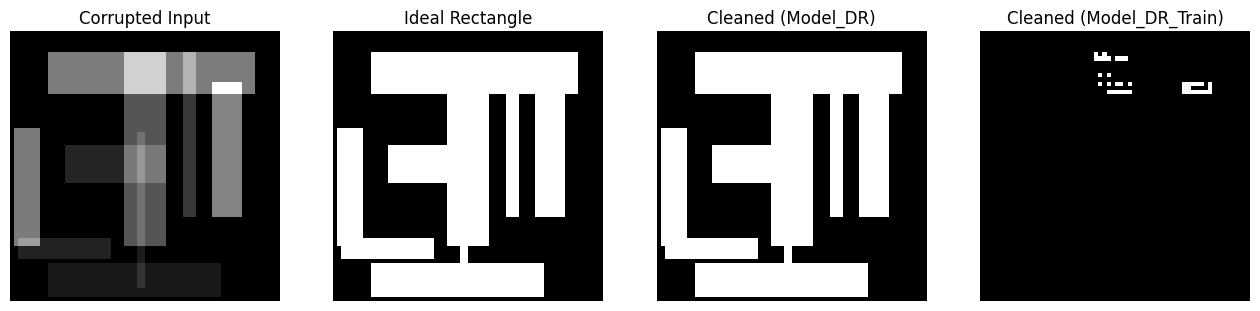

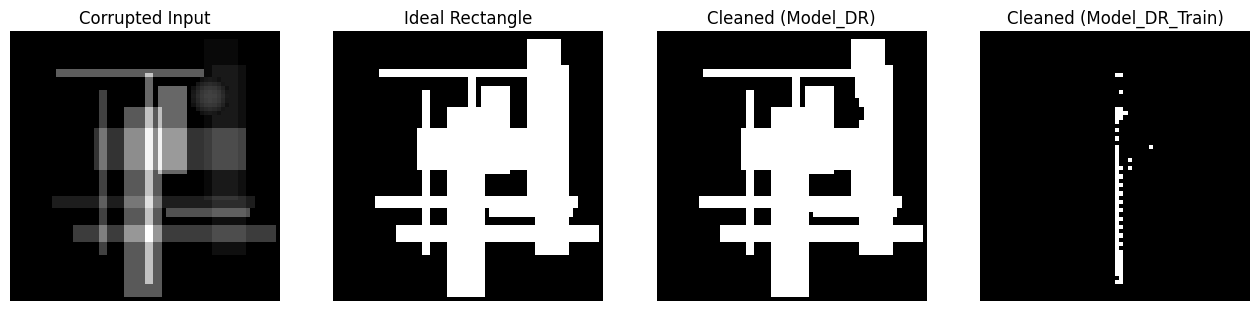

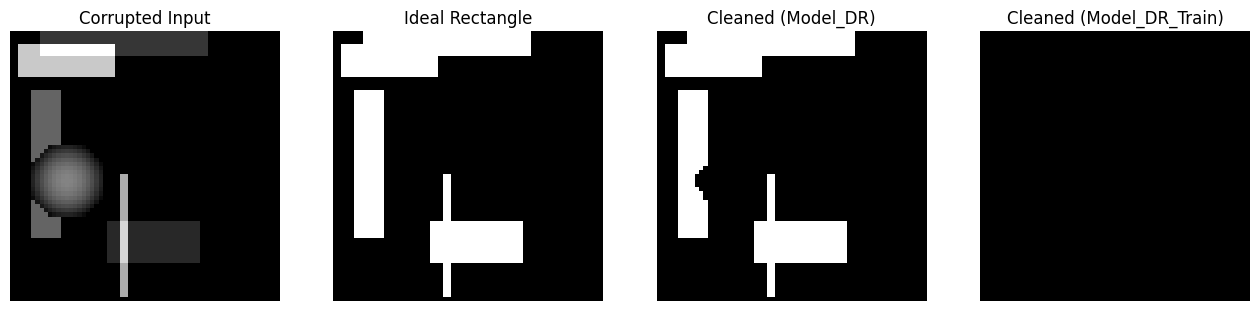

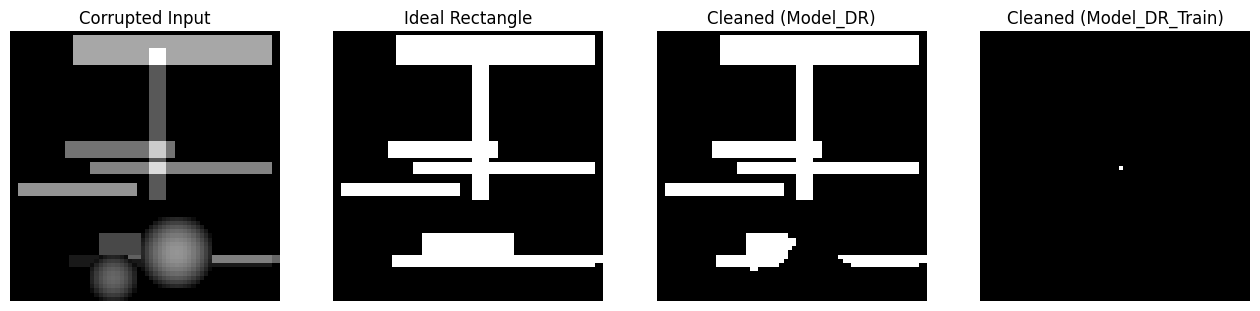

In [45]:
# Training parameters
num_epochs = 30
batch_size = 16
num_batches = 10  # number of mini-batches per epoch

# Create two models:
# Model_DR: Trained on gen_dr (original, high-density domain)
model_dr = UNet(n_channels=1, n_classes=2, size=64).cuda()
optimizer_dr = optim.Adam(model_dr.parameters(), lr=1e-3)

# Model_DR_Train: Trained on gen_dr_train (lower density domain)
model_dr_train = UNet(n_channels=1, n_classes=2, size=64).cuda()
optimizer_dr_train = optim.Adam(model_dr_train.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

print("Starting training...\n")
for epoch in range(num_epochs):
    # --- Train Model_DR on gen_dr ---
    model_dr.train()
    train_loss_dr = 0.0
    for _ in range(num_batches):
        # Get training batch from original domain:
        corrupted, ideal_rect = gen_dr(batch_size)   # corrupted image, ideal rectangle mask
        # Also get discs
        disc_images = gen_d(batch_size)
        disc_ideal = (disc_images > 0).float()

        inputs = corrupted.float().cuda()         # [B, 1, H, W]
        rect_target = ideal_rect.float().cuda()     # [B, 1, H, W]
        disc_target = disc_ideal.cuda()             # [B, 1, H, W]

        optimizer_dr.zero_grad()
        outputs = model_dr(inputs)  # outputs shape: [B, 2, H, W]
        # Preserve channel dimension:
        rect_out = outputs[:, 0:1, :, :]
        disc_out = outputs[:, 1:2, :, :]

        loss_rect = criterion(rect_out, rect_target)
        loss_disc = criterion(disc_out, disc_target)
        loss = loss_rect + loss_disc

        loss.backward()
        optimizer_dr.step()
        train_loss_dr += loss.item()
    avg_loss_dr = train_loss_dr / num_batches

    # --- Train Model_DR_Train on gen_dr_train ---
    model_dr_train.train()
    train_loss_dr_train = 0.0
    for _ in range(num_batches):
        # Get training batch from the lower density domain:
        corrupted, ideal_rect = gen_dr_train(batch_size)
        disc_images = gen_d(batch_size)
        disc_ideal = (disc_images > 0).float()

        inputs = corrupted.float().cuda()
        rect_target = ideal_rect.float().cuda()
        disc_target = disc_ideal.cuda()

        optimizer_dr_train.zero_grad()
        outputs = model_dr_train(inputs)
        rect_out = outputs[:, 0:1, :, :]
        disc_out = outputs[:, 1:2, :, :]

        loss_rect = criterion(rect_out, rect_target)
        loss_disc = criterion(disc_out, disc_target)
        loss = loss_rect + loss_disc

        loss.backward()
        optimizer_dr_train.step()
        train_loss_dr_train += loss.item()
    avg_loss_dr_train = train_loss_dr_train / num_batches

    print(f"Epoch [{epoch+1}/{num_epochs}] | Model_DR Train Loss: {avg_loss_dr:.4f} | Model_DR_Train Train Loss: {avg_loss_dr_train:.4f}")

print("\nTraining complete.\n")

# --- Evaluation on a common test set (using gen_dr) ---
model_dr.eval()
model_dr_train.eval()
with torch.no_grad():
    # Use gen_dr as the test distribution.
    test_corrupted, test_rect_ideal = gen_dr(4)
    test_disc_images = gen_d(4)

    test_inputs = test_corrupted.float().cuda()

    # Get outputs from both models
    outputs_dr = model_dr(test_inputs)
    outputs_dr_train = model_dr_train(test_inputs)

    # Extract channels and apply sigmoid to get probabilities:
    test_rect_prob_dr = torch.sigmoid(outputs_dr[:, 0:1, :, :])
    test_disc_prob_dr = torch.sigmoid(outputs_dr[:, 1:2, :, :])
    test_rect_prob_dr_train = torch.sigmoid(outputs_dr_train[:, 0:1, :, :])
    test_disc_prob_dr_train = torch.sigmoid(outputs_dr_train[:, 1:2, :, :])

    # Combine the predictions using a multiplicative rule:
    final_rect_dr = ((test_rect_prob_dr > 0.5) & (test_disc_prob_dr < 0.5)).float()
    final_rect_dr_train = ((test_rect_prob_dr_train > 0.5) & (test_disc_prob_dr_train < 0.5)).float()
    # Compute IoU scores (move targets to CPU for compute_iou)
    iou_dr = compute_iou(final_rect_dr.cpu(), test_rect_ideal.float().cpu())
    iou_dr_train = compute_iou(final_rect_dr_train.cpu(), test_rect_ideal.float().cpu())

    print("Test IoU for Model_DR (gen_dr):", iou_dr.item())
    print("Test IoU for Model_DR_Train (gen_dr_train):", iou_dr_train.item())

# --- Visualization: Compare outputs side-by-side ---
test_inputs_np = test_inputs.cpu().numpy()
test_rect_ideal_np = test_rect_ideal.cpu().numpy()
final_rect_dr_np = final_rect_dr.cpu().numpy()
final_rect_dr_train_np = final_rect_dr_train.cpu().numpy()

for i in range(4):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(test_inputs_np[i, 0], cmap='gray')
    axs[0].set_title("Corrupted Input")
    axs[0].axis("off")

    axs[1].imshow(test_rect_ideal_np[i, 0], cmap='gray')
    axs[1].set_title("Ideal Rectangle")
    axs[1].axis("off")

    axs[2].imshow(final_rect_dr_np[i, 0], cmap='gray')
    axs[2].set_title("Cleaned (Model_DR)")
    axs[2].axis("off")

    axs[3].imshow(final_rect_dr_train_np[i, 0], cmap='gray')
    axs[3].set_title("Cleaned (Model_DR_Train)")
    axs[3].axis("off")

    plt.show()

On observe que la performance du model entrainé avec gen_dr_train est horrible dans l'absolue et encore plus comparativement.

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

Une methode assez naive (et probablement incorrecte) qui vient à l'esprit et de générer plusieurs images en utilisant gent_dr_train et de les combiner afin d'augmenter le densité des figure géometriques.


\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).

Le problème abordé dans l'article est un problème de segmentation. La méthode d'augmentation de données utilisée est la déformation d'image, spécifiquement la déformation élastique.